.. meta::
   :description: A guide which introduces the most important steps to get started with pymoo, an open-source multi-objective optimization framework in Python.

.. meta::
   :keywords: Multi-objective Optimization, Python, Evolutionary Computation, Optimization Test Problem, Hypervolume

In [27]:
%%capture
%run part_2.ipynb

# Part IV: Analysis of Convergence

Great! So far, we have executed an algorithm and already obtained a solution set. But let us not stop here without knowing how the algorithm has performed. This will also answer how we should define a termination criterion if we solve the problem again. The convergence analysis shall consider two cases, i) the Pareto-front is not known, or ii) the Pareto-front has been derived analytically or a reasonable approximation exists.

## Result

To further check how close the results match the analytically derived optimum from before, we have to convert the objective space values to the original definition where the second objective $f_2$ was maximized. Plotting then the Pareto-front shows how close the algorithm was able to converge.

In [28]:
from pymoo.util.misc import stack

class MyTestProblem(MyProblem):

    def _calc_pareto_front(self, flatten=True, *args, **kwargs):
        f2 = lambda f1: ((f1/100) ** 0.5 - 1)**2
        F1_a, F1_b = np.linspace(1, 16, 300), np.linspace(36, 81, 300)
        F2_a, F2_b = f2(F1_a), f2(F1_b)
        
        pf_a = np.column_stack([F1_a, F2_a])
        pf_b = np.column_stack([F1_b, F2_b])
        
        return stack(pf_a, pf_b, flatten=flatten)

    def _calc_pareto_set(self, *args, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)
        
        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten) 
    
problem = MyTestProblem()

For IGD the Pareto front needs to be known or to be approximated.
In our framework the Pareto front of **test problems** can be obtained by:

In [29]:
pf_a, pf_b = problem.pareto_front(use_cache=False, flatten=False)

In [30]:
pf = problem.pareto_front(use_cache=False, flatten=True)

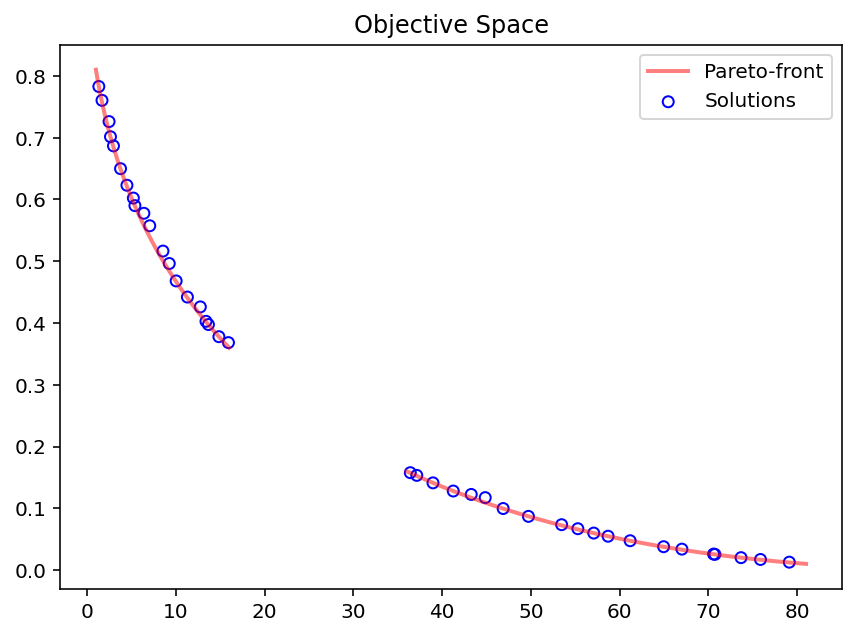

In [31]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='b', label="Solutions")
plt.plot(pf_a[:, 0], pf_a[:, 1], alpha=0.5, linewidth=2.0, color="red", label="Pareto-front")
plt.plot(pf_b[:, 0], pf_b[:, 1], alpha=0.5, linewidth=2.0, color="red")
plt.title("Objective Space")
plt.legend()
plt.show()

No matter if the optimum for your problem is known or not, we encourage all end-users of *pymoo* not to skip the analysis of the obtained solution set. Visualizations for high-dimensional objective spaces (in design and/or objective space) are also provided and shown [here](visualization/index.ipynb).

In Part II, we have run the algorithm without storing, keeping track of the optimization progress, and storing information. For analyzing the convergence, historical data need to be stored. One way of doing that is enabling the `save_history` flag, which will store a deep-copy of the algorithm object in each iteration and save it in the `Result` object. This approach is more memory-intensive (especially for many iterations) but has the advantage that **any** algorithm dependent variable can be analyzed posteriorly.

A not negligible step is the post-processing after having obtained the results. We strongly recommend not only analyzing the final result but also the algorithm's behavior. This gives more insights into the convergence of the algorithm.

For such an analysis, intermediant steps of the algorithm need to be considered. This can either be achieved by:

- A `Callback` class storing the necessary information in each iteration of the algorithm.
- Enabling the `save_history` flag when calling the minimize method to store a deepcopy of the algorithm's objective each iteration.

We provide some more details about each variant in our [convergence](misc/convergence.ipynb) tutorial.
As you might have already seen, we have set `save_history=True` when calling the `minmize` method in this getting started guide and, thus, will you the `history` for our analysis. Moreover, we need to decide what metric should be used to measure the performance of our algorithm. In this tutorial, we are going to use `Hypervolume` and `IGD`. Feel free to look at our [performance indicators](misc/performance_indicator.ipynb) to find more information about metrics to measure the performance of multi-objective algorithms.

In [32]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               ("n_gen", 40),
               seed=1,
               save_history=True,
               verbose=False)

X, F = res.opt.get("X", "F")

hist = res.history
print(len(hist))

40


From the `history` it is relatively easy to extract the information we need for an analysis. 

In [33]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:
    
    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)
    
    # retrieve the optimum from the algorithm
    opt = algo.opt
    
    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

## Constraint Satisfaction

First, let us quickly see when the first feasible solution has been found:

In [34]:
k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

At least one feasible solution in Generation 0 after 40 evaluations.


Because this problem does not really have a lot of complexity a feasible solution was found right away. Nevertheless, for your optimization problem this can be completely different and is also worth to be analyzed first.

Whole population feasible in Generation 5 after 90 evaluations.


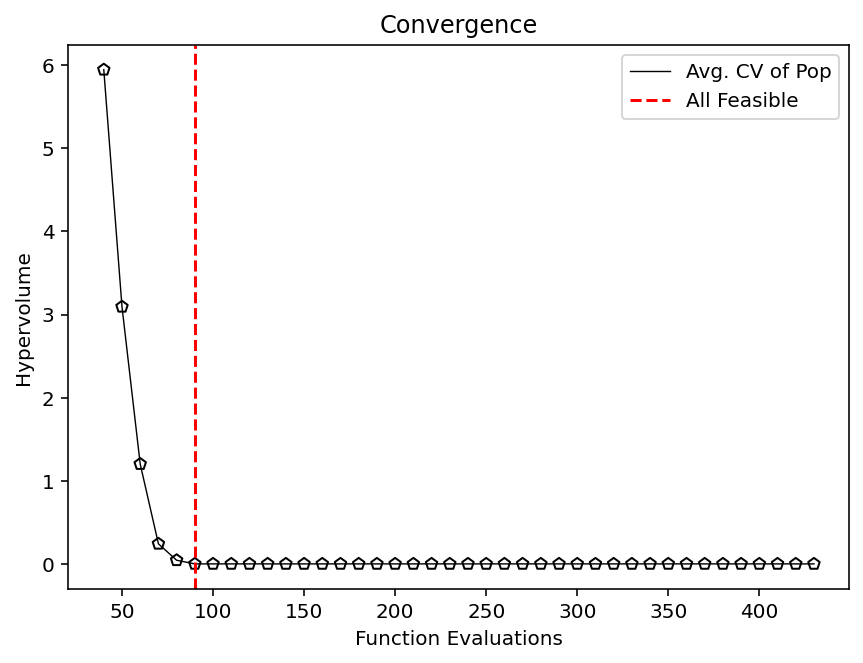

In [35]:
# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population 
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

## Pareto-front is unknown

Clearly, if the Pareto-front is not known we can not know if the algorithm has converged to the true optimum or not. At least not without any further information. However, what we can do is to see when the algorithm has made most of its progress during optimization, for tells us for instance if the number of iterations could be less or more. Moreover, could the metrics shown below be used to compare one algorithm with another.

In multi-objective optimization **normalization** the very important. For that reason you see below that the Hypervolume is based on a normalized set normalized by the bounds (idea)
More details about it will be shown in Part IV. 

### Hypvervolume (HV)

Hypervolume is a very well-known performance indicator for multi-objective problems. It is known to be Pareto-compliant and is based on the volume between a predefined reference point and the solution provided. Hypervolume requires to define a reference point `ref_point`, which shall be larger than the maximum value of the Pareto front. 

In [36]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

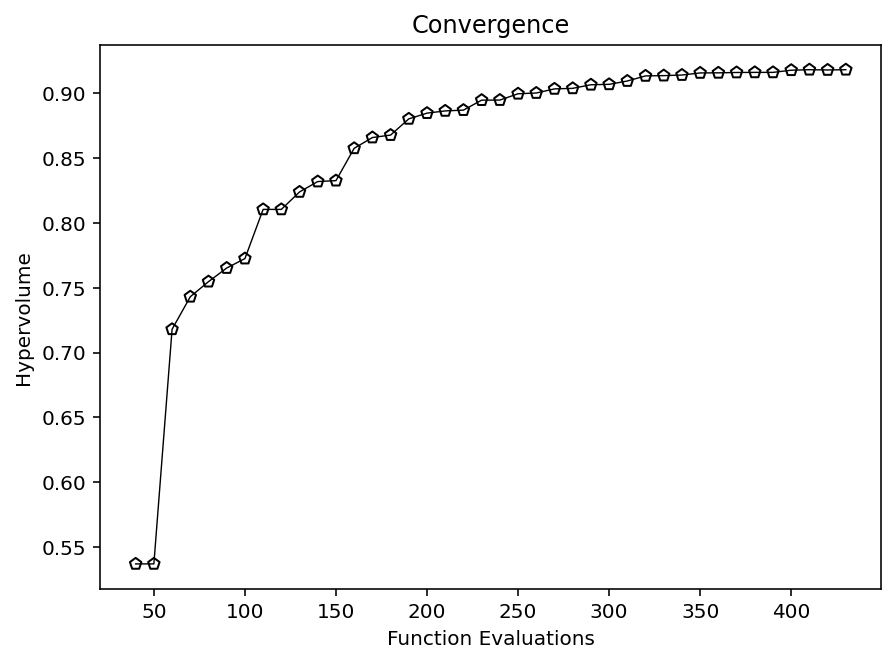

In [37]:
from pymoo.performance_indicator.hv import Hypervolume

metric = Hypervolume(ref_point= np.array([1.1, 1.1]), 
                     norm_ref_point=False,
                     zero_to_one=True, 
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]  

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

**Note:** Hypervolume becomes computationally expensive with increasing dimensionality. The exact hypervolume can be calculated efficiently for 2 and 3 objectives. For higher dimensions, some researchers use a hypervolume approximation, which is not available yet in pymoo.

### Running Metric

Another way of analyzing a run when the true Pareto front is **not** known is the recently proposed [running metric](https://www.egr.msu.edu/~kdeb/papers/c2020003.pdf). The running metric shows the difference in the objective space from one generation to another and uses the algorithm's survival to visualize the improvement.
This metric is also being used in pymoo to determine the termination of a multi-objective optimization algorithm if no default termination criteria have been defined.

For instance, this analysis reveals that the algorithm was able to improve from the 4th to the 5th generation significantly.

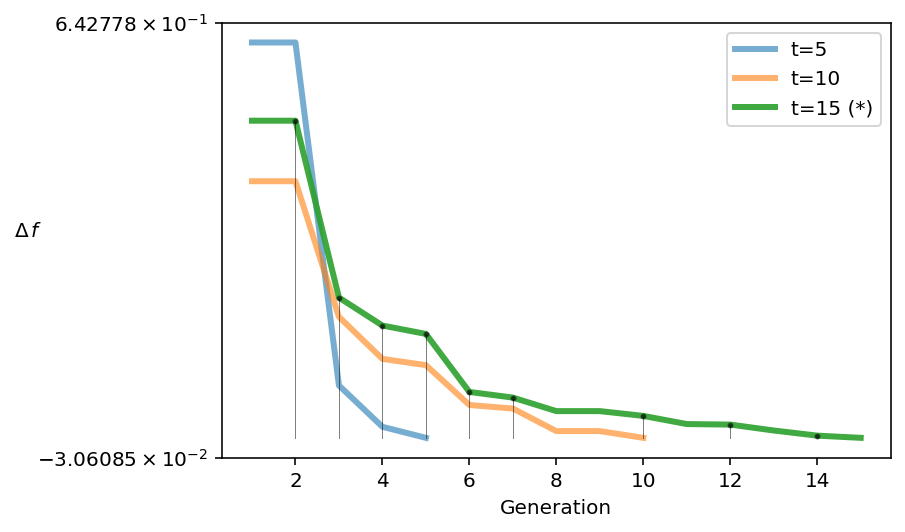

In [43]:
from pymoo.util.running_metric import RunningMetric

running = RunningMetric(delta_gen=5, 
                        n_plots=3,
                        only_if_n_plots=True,
                        key_press=False,
                        do_show=True)

for algorithm in res.history[:15]:
    running.notify(algorithm)

Plotting until the final population shows the the algorithm seems to have more a less converged and only a small improvement has been made.

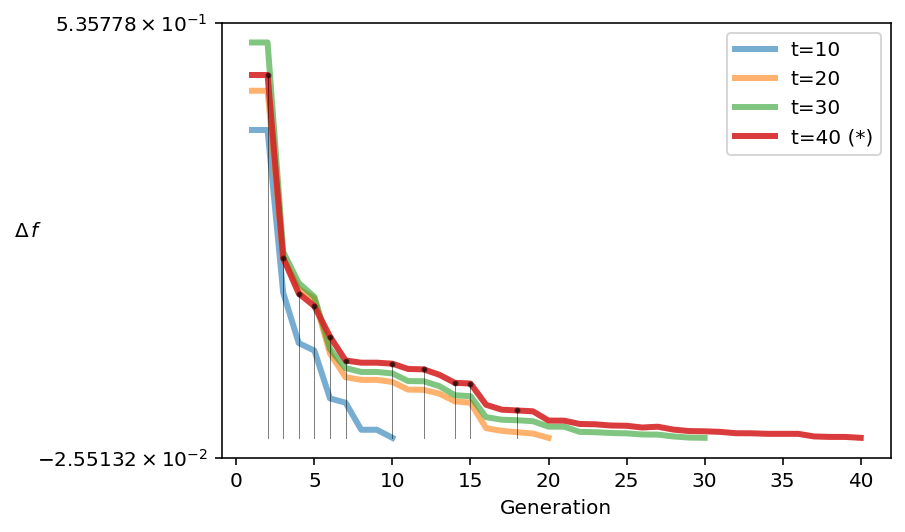

In [39]:
from pymoo.util.running_metric import RunningMetric

running = RunningMetric(delta_gen=10, 
                        n_plots=4,
                        only_if_n_plots=True,
                        key_press=False, 
                        do_show=True)

for algorithm in res.history:
    running.notify(algorithm)

## Pareto-front is known or approximated

### IGD/GD/IGD+/GD+

The Pareto-front for a problem can either be provided manually or directly being implemented in the `Problem` definition. For this test problem.........

For real-world problems, you have to use an **approximation**. An approximation can be obtained by running an algorithm a couple of times and extracting the non-dominated solutions out of all solution sets. If you have only a single run, an alternative is to use the obtain a non-dominated set of solutions as an approximation. However, the result does then only indicate how much the algorithm's progress in converging to the final set.

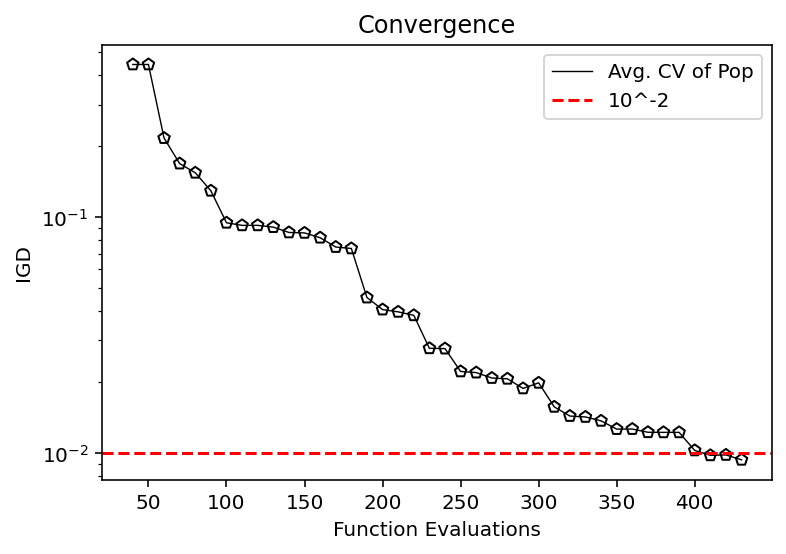

In [40]:
from pymoo.performance_indicator.igd import IGD

metric = IGD(pf, zero_to_one=True)

igd = [metric.do(_F) for _F in hist_F]

plt.plot(n_evals, igd,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD")
plt.yscale("log")
plt.legend()
plt.show()

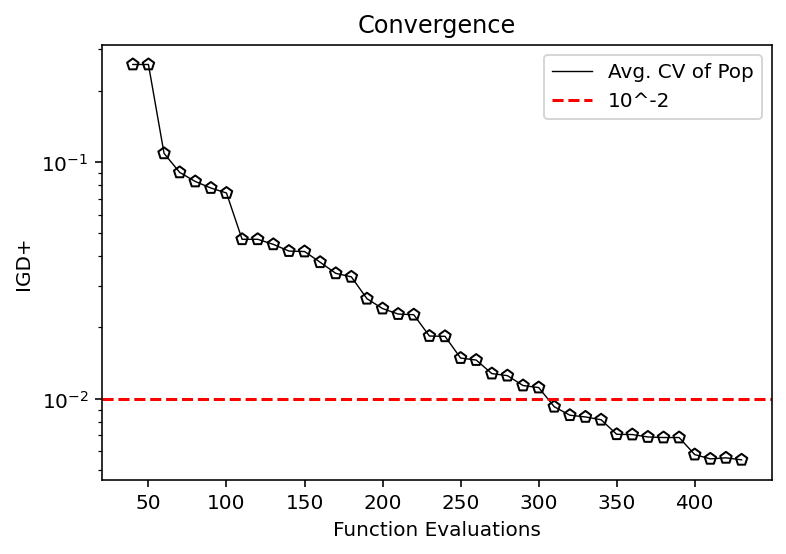

In [41]:
from pymoo.performance_indicator.igd_plus import IGDPlus

metric = IGDPlus(pf, zero_to_one=True)

igd = [metric.do(_F) for _F in hist_F]

plt.plot(n_evals, igd,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD+")
plt.yscale("log")
plt.legend()
plt.show()